## 对抗生成网络案例 ##


<img src="jpg/3.png" alt="FAO" width="590" >

- 判别器 : 火眼金睛，分辨出生成和真实的 <br /> 
<br /> 
- 生成器 : 瞒天过海，骗过判别器 <br /> 
<br /> 
- 损失函数定义 : 一方面要让判别器分辨能力更强，另一方面要让生成器更真 <br /> 
<br /> 

<img src="jpg/1.jpg" alt="FAO" width="590" >

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# 导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/data')

Extracting /data\train-images-idx3-ubyte.gz
Extracting /data\train-labels-idx1-ubyte.gz
Extracting /data\t10k-images-idx3-ubyte.gz
Extracting /data\t10k-labels-idx1-ubyte.gz


## 网络架构

### 输入层 ：待生成图像（噪音）和真实数据

### 生成网络：将噪音图像进行生成

### 判别网络：
- （1）判断真实图像输出结果 
- （2）判断生成图像输出结果

### 目标函数：
- （1）对于生成网络要使得生成结果通过判别网络为真 
- （2）对于判别网络要使得输入为真实图像时判别为真 输入为生成图像时判别为假

<img src="jpg/2.png" alt="FAO" width="590" >

## Inputs

In [3]:
#真实数据和噪音数据
def get_inputs(real_size, noise_size):
    
    real_img = tf.placeholder(tf.float32, [None, real_size])
    noise_img = tf.placeholder(tf.float32, [None, noise_size])
    
    return real_img, noise_img

## 生成器
* noise_img: 产生的噪音输入
* n_units: 隐层单元个数
* out_dim: 输出的大小（28 * 28 * 1）

In [4]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
  
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

## 判别器
* img：输入
* n_units：隐层单元数量
* reuse：由于要使用两次

In [5]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):

    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

## 网络参数定义
* img_size：输入大小
* noise_size：噪音图像大小
* g_units：生成器隐层参数
* d_units：判别器隐层参数
* learning_rate：学习率

In [6]:
img_size = mnist.train.images[0].shape[0]

noise_size = 100

g_units = 128

d_units = 128

learning_rate = 0.001

alpha = 0.01

## 构建网络

In [7]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

### 目标函数：
- （1）对于生成网络要使得生成结果通过判别网络为真 
- （2）对于判别网络要使得输入为真实图像时判别为真 输入为生成图像时判别为假

<img src="jpg/2.png" alt="FAO" width="590" >

In [8]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))

## 优化器

In [9]:
train_vars = tf.trainable_variables()

# generator
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 训练

In [10]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "判别器损失: {:.4f}(判别真实的: {:.4f} + 判别生成的: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "生成器损失: {:.4f}".format(train_loss_g))    
        
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 保存样本
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        
        saver.save(sess, './checkpoints/generator.ckpt')

# 保存到本地
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... 判别器损失: 0.0419(判别真实的: 0.0014 + 判别生成的: 0.0405)... 生成器损失: 3.8008
Epoch 2/300... 判别器损失: 0.2536(判别真实的: 0.1991 + 判别生成的: 0.0544)... 生成器损失: 4.1958
Epoch 3/300... 判别器损失: 0.8420(判别真实的: 0.3731 + 判别生成的: 0.4689)... 生成器损失: 6.2357
Epoch 4/300... 判别器损失: 0.8232(判别真实的: 0.1771 + 判别生成的: 0.6461)... 生成器损失: 1.7907
Epoch 5/300... 判别器损失: 1.2470(判别真实的: 0.7575 + 判别生成的: 0.4895)... 生成器损失: 2.9907
Epoch 6/300... 判别器损失: 1.6540(判别真实的: 0.7277 + 判别生成的: 0.9263)... 生成器损失: 0.7700
Epoch 7/300... 判别器损失: 1.8045(判别真实的: 0.9542 + 判别生成的: 0.8503)... 生成器损失: 1.5695
Epoch 8/300... 判别器损失: 1.5491(判别真实的: 1.1568 + 判别生成的: 0.3923)... 生成器损失: 2.3933
Epoch 9/300... 判别器损失: 1.4013(判别真实的: 0.4586 + 判别生成的: 0.9427)... 生成器损失: 1.5472
Epoch 10/300... 判别器损失: 2.0657(判别真实的: 1.4063 + 判别生成的: 0.6594)... 生成器损失: 1.8785
Epoch 11/300... 判别器损失: 1.0202(判别真实的: 0.6609 + 判别生成的: 0.3592)... 生成器损失: 3.4438
Epoch 12/300... 判别器损失: 0.9237(判别真实的: 0.5010 + 判别生成的: 0.4227)... 生成器损失: 1.9403
Epoch 13/300... 判别器损失: 1.2636(判别真实的: 0.8710 + 判别生成的: 0.3926)... 生成器损失: 1.

# loss迭代曲线

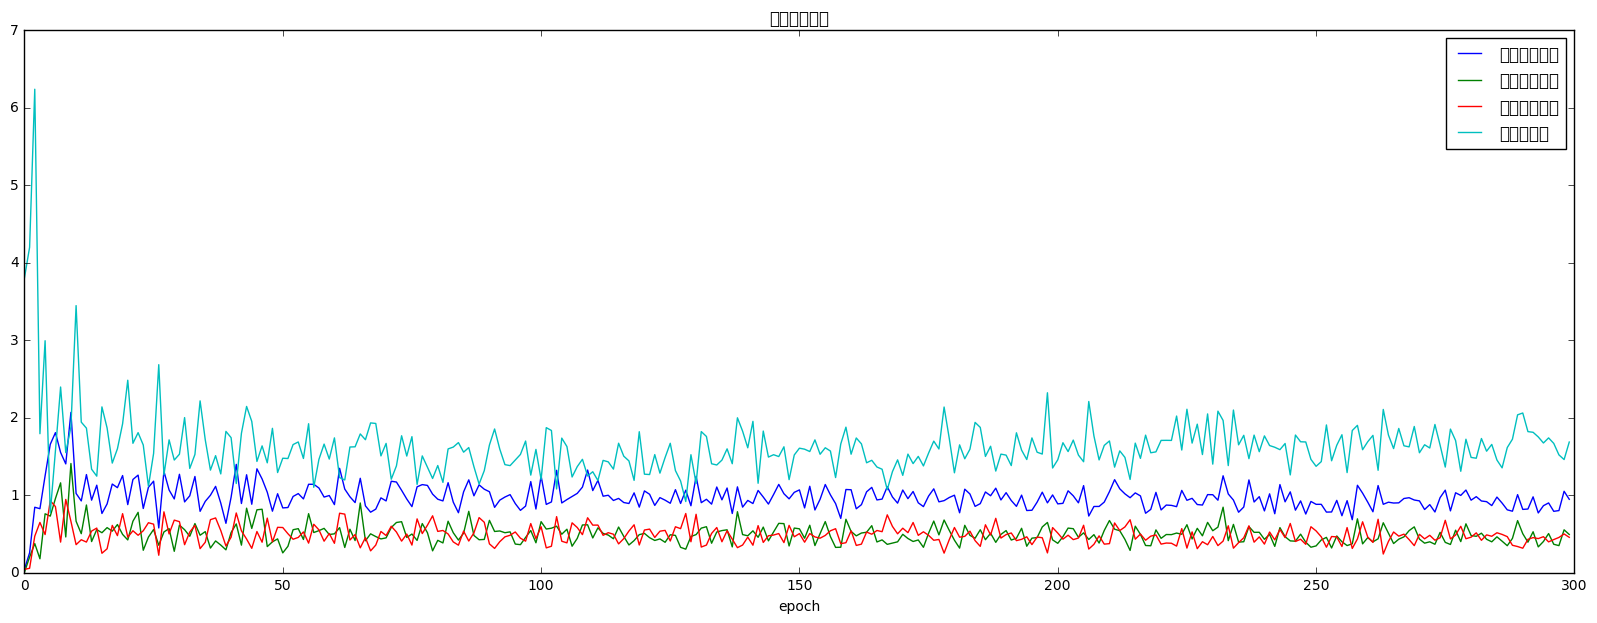

In [11]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='判别器总损失')
plt.plot(losses.T[1], label='判别真实损失')
plt.plot(losses.T[2], label='判别生成损失')
plt.plot(losses.T[3], label='生成器损失')
plt.title("对抗生成网络")
ax.set_xlabel('epoch')
plt.legend()

# 生成结果

In [12]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [13]:
#samples是保存的结果 epoch是第多少次迭代
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

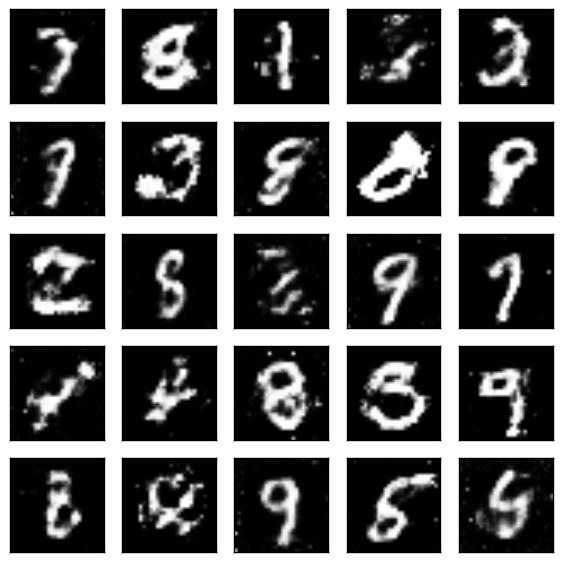

In [14]:
_ = view_samples(-1, samples) # 显示最终的生成结果

# 显示整个生成过程图片

In [15]:
# 指定要查看的轮次
epoch_idx = [10, 30, 60, 90, 120, 150, 180, 210, 240, 290] 
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

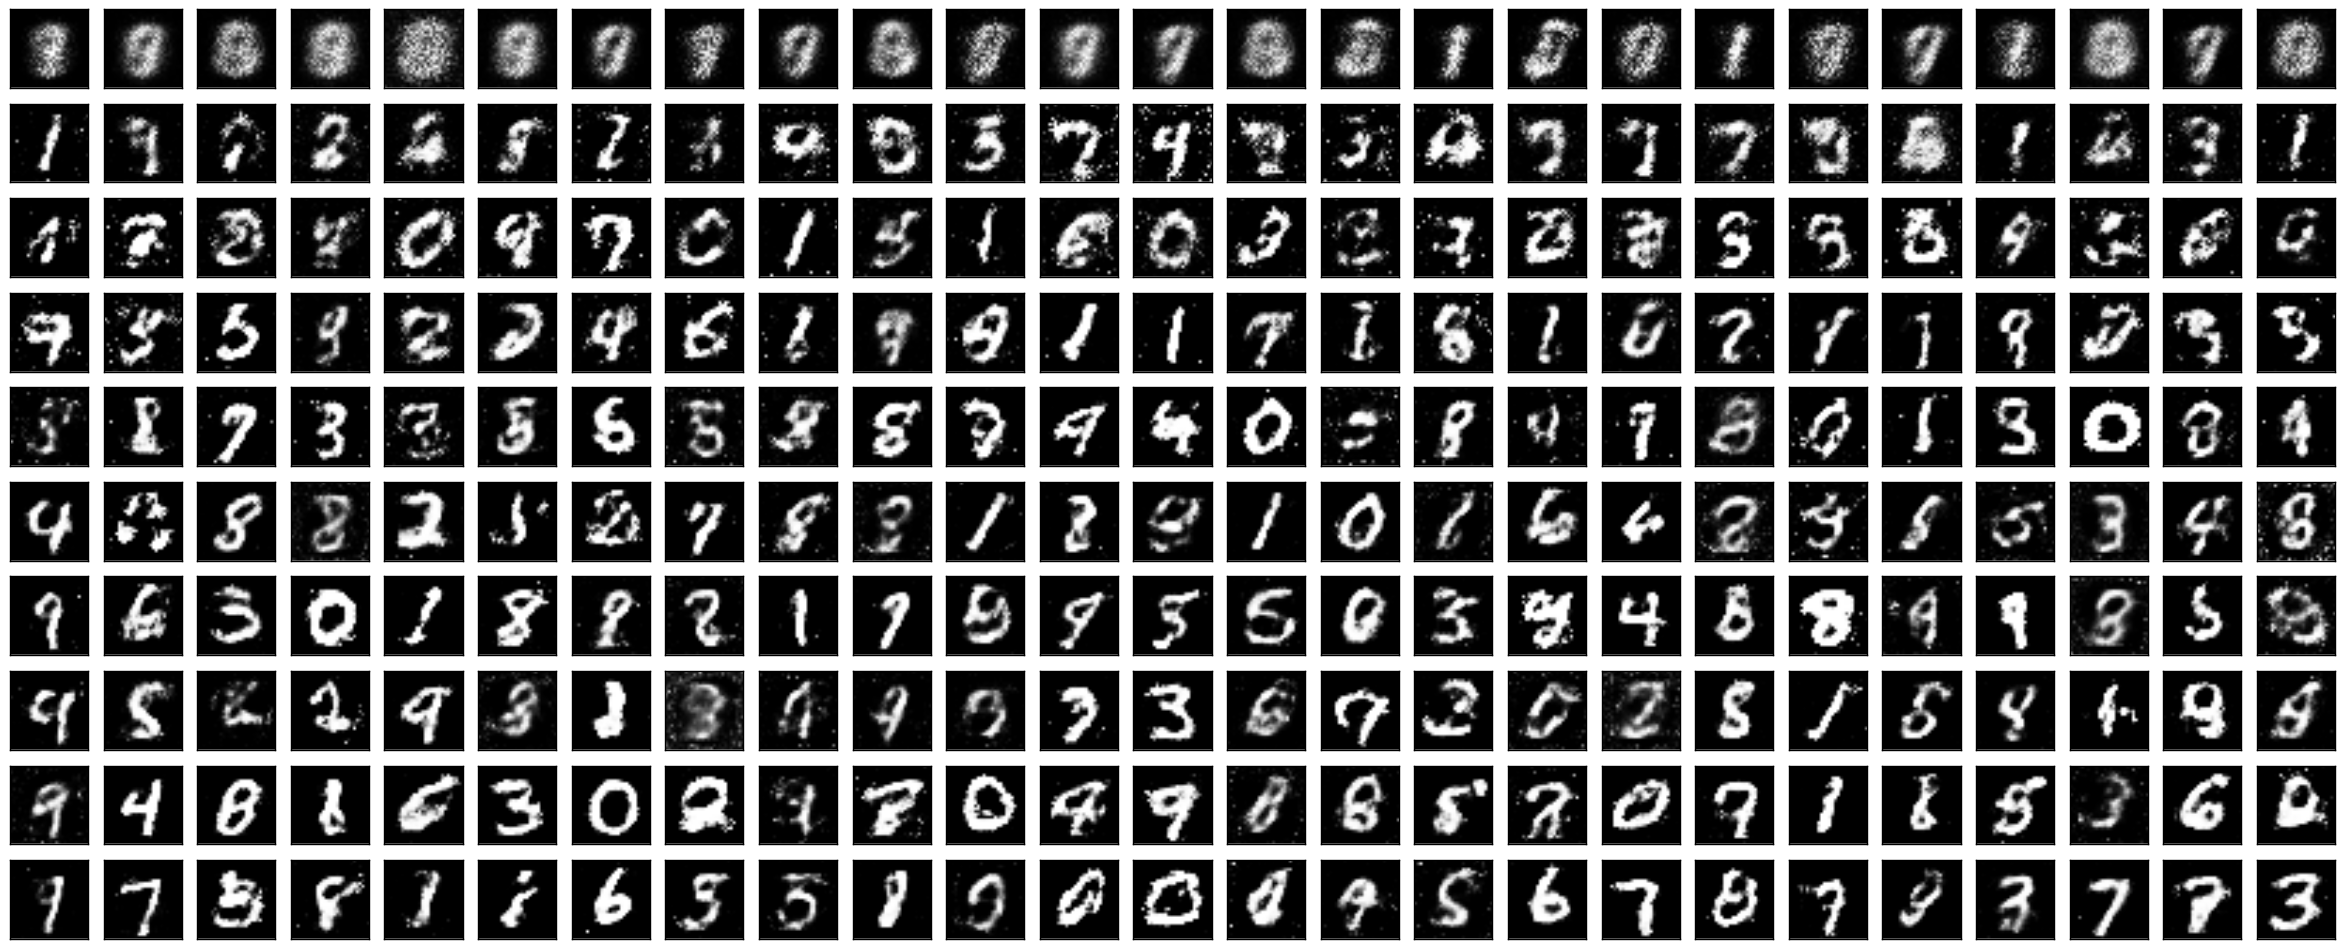

In [16]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# 生成新的图片

In [17]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})


INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


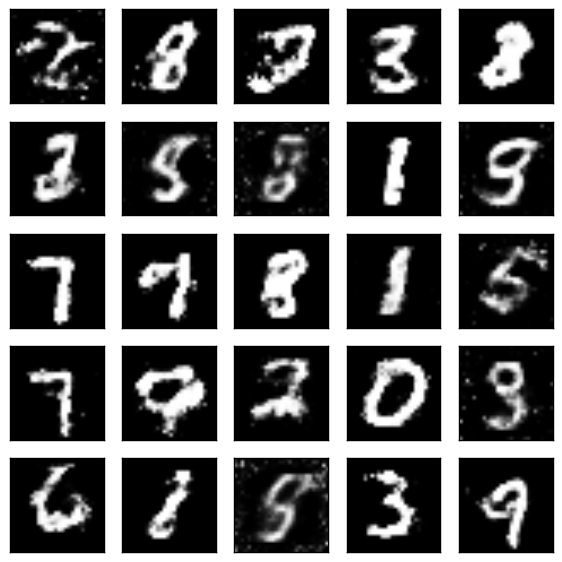

In [18]:
_ = view_samples(0, [gen_samples])